In [4]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy.signal import find_peaks
import SpectralEvents.spectralevents as se
import matplotlib.animation as animation
from tfr_utils import compute_tfr
%matplotlib inline

In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [ ]:
SESSIONS = [766640955, 768515987]

In [7]:
# # load project cache
# manifest_path = f"../data/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json"
# cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

In [8]:
# get the metadata tables
# units_table = cache.get_unit_table()

channels_table = cache.get_channel_table()

behavior_sessions_table = cache.get_behavior_session_table()

ecephys_sessions_table = cache.get_ecephys_session_table()

probes = cache.get_probe_table()
valid_lfp = probes[probes['has_lfp_data']]

print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

AttributeError: 'EcephysProjectCache' object has no attribute 'get_channel_table'

In [5]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
running_speed = session.running_speed

/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [6]:
lfp = session.get_lfp(1064735073)

/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [7]:
def window_lfp(lfp, alignment_window, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([alignment_window])
    
    if trial_ids is None:
        trial_ids = [1]
        
    # inds = pd.MultiIndex.from_product((trial_ids, alignment_window), 
    #                                   names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')

    return ds['aligned_lfp']

def apply_specparam(spectra, freqs, specparam_settings, n_jobs=-1):
    """
    Apply spectral parameterization to 3D array of power spectra.

    Parameters
    ----------
    spectra : 3d array
        Power spectra, with dimensions [n_spectra, n_freqs, n_times].
    freqs : 1d array
        Frequency values for the power spectra.
    specparam_settings : dict
        Settings for the spectral parameterization.
    n_jobs : int
        Number of parallel jobs to run.

    Returns
    -------
    exponent : 2d array
        Aperiodic exponents for each power spectrum. Dimensions are 
        [n_spectra, n_times].
    """
    
    # imports
    from specparam import SpectralGroupModel
    from specparam.objs import fit_models_3d, combine_model_objs
    
    spectra_rs = np.swapaxes(spectra, 1, 2) # make freq dimension last
    sm = SpectralGroupModel(**specparam_settings)
    sgm = fit_models_3d(sm, freqs, spectra_rs, n_jobs=n_jobs)
    sgm = combine_model_objs(sgm)
    
    return sgm

In [8]:
stim_presentations = session.stimulus_presentations
spontaneous = stim_presentations[stim_presentations['stimulus_name'].str.contains('spont')]


spontaneous_times  = (spontaneous.start_time.values[1], spontaneous.end_time.values[1])



In [9]:
spont_window = np.arange(spontaneous_times[0], spontaneous_times[1], 1/500)
spont_lfp = window_lfp(lfp, spont_window).squeeze().T
spont_lfp['time'] = spont_lfp.time - spont_lfp.time.values[0]
spont_times = spont_lfp.time.values

In [10]:
# N = 73
# fs = 500
# delay = 0.5 * (N-1) / fs
# taps_alpha = scipy.signal.firwin(numtaps=73, cutoff=[4, 6], fs=fs, window='hamming', pass_zero=False)

chan_idx = 74
# # chan_idx = 10
# lfp_alpha = scipy.signal.lfilter(taps_alpha, 1.0, spont_lfp[chan_idx,:])
# envelope_alpha = np.abs(scipy.signal.hilbert(lfp_alpha))
# # envelope_alpha = np.diff(np.abs(lfp_alpha[:,chan_idx]))

In [11]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]
lfp_chan_names = [chans.loc[c]['structure_acronym'] for c in lfp.channel.values]
color_dict = {name: f'C{idx}' for idx, name in enumerate(np.unique(lfp_chan_names))}
lfp_color_map = [color_dict[name] for name in lfp_chan_names]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()

In [12]:
region_names = np.unique(lfp_chan_names)
region_pos = list()
for name in region_names:
    region_chans = np.where(np.isin(lfp_chan_names, name))[0]
    region_pos.append(np.mean(region_chans))

In [13]:
window_len = 500
t_idx = 0
bounds = range(t_idx, t_idx+window_len)
plot_times = spont_times[t_idx:t_idx+window_len]

In [14]:
samp_freq = 500

# set parameters
freq_bounds = [1, 20]  # fequency values (Hz) over which to calculate TFR
tfr_times = np.linspace(spont_lfp.time.values[0], spont_lfp.time.values[-1], len(spont_lfp.time.values))  # seconds
# tfrs = se.tfr(spont_lfp[chan_idx, :], freqs, samp_freq)
tfrs, freqs = compute_tfr(spont_lfp[chan_idx, :].values.reshape(1, 1,-1), samp_freq, freqs=freq_bounds)

freq_mask = np.logical_and(freqs > 1, freqs < 10)
envelope_alpha = np.sum(tfrs[0, 0, freq_mask, :], axis=0)

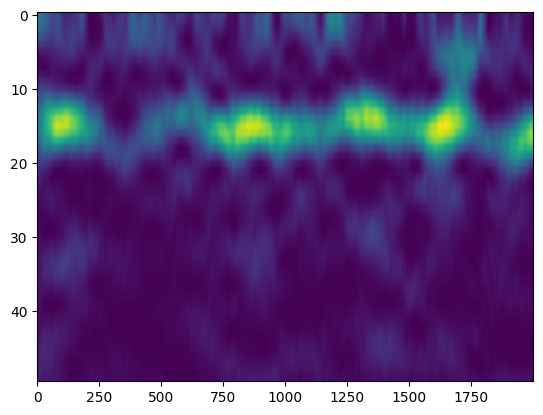

In [16]:
plt.imshow(tfrs[0,0,:,:2000], aspect='auto')

In [25]:
sgm = apply_specparam(tfrs[0,:,:,:1000], freqs, specparam_settings={'peak_width_limits': [2, 8], 'aperiodic_mode': 'knee'})

Fitting model across 1000 power spectra.


/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specpar

Model fitting was unsuccessful.Model fitting was unsuccessful.

Model fitting was unsuccessful.
Model fitting was unsuccessful.


/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
/opt/conda/lib/python3.9/site-packages/specparam/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


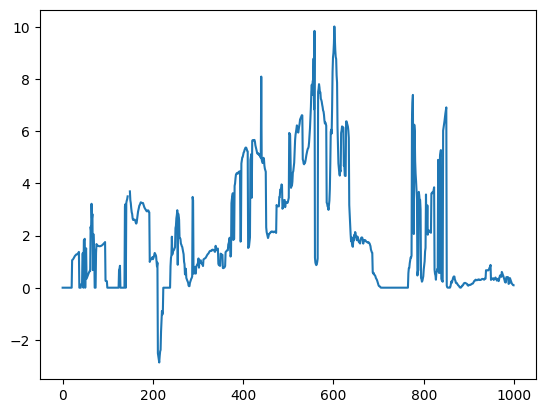

In [26]:
plt.plot(sgm.get_params('aperiodic', 'exponent'))

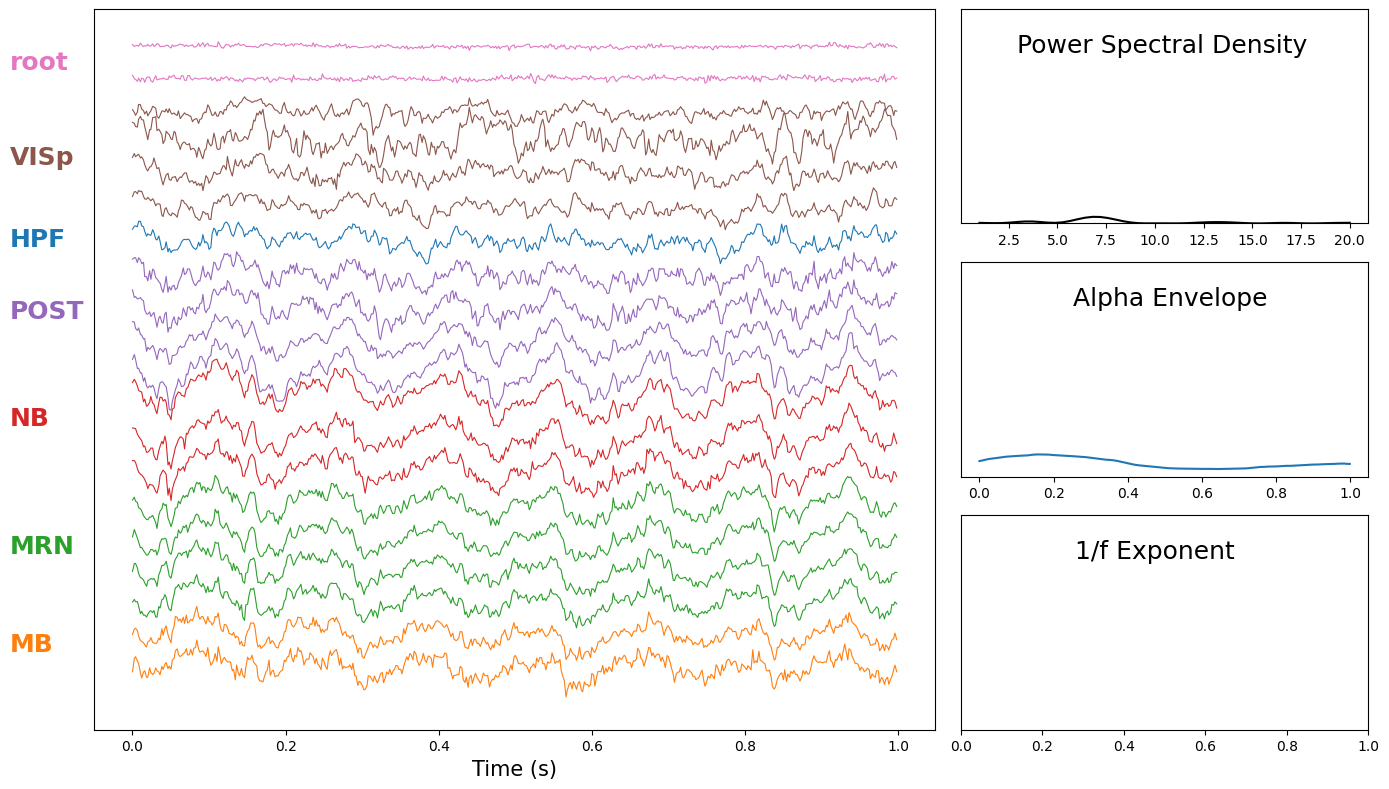

In [43]:
skip_factor = 5
fig = plt.figure(figsize=(14,8), tight_layout=True)
ax1 = plt.subplot2grid((3, 3), (0, 2), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((3, 3), (1, 2), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3, 3), (2, 2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((3, 3), (0, 0), rowspan=3, colspan=2)

lfp_offset = np.arange(0, spont_lfp.shape[0]).reshape(-1,1)
plot_lfp = ((spont_lfp[::skip_factor, bounds].values / np.max(spont_lfp.values))) * 10 + lfp_offset[::skip_factor]

lines_lfp = list()
for line_idx in range(0, spont_lfp.shape[0], skip_factor):
    plot_lfp = ((spont_lfp[line_idx, bounds].values / np.max(spont_lfp.values))) * 10 + lfp_offset[line_idx]

    temp_line = ax4.plot(plot_times, plot_lfp, linewidth=0.8, color=lfp_color_map[line_idx])
    lines_lfp.append(temp_line)

# plt.gca().invert_yaxis()
# ax4.set_yticks(region_pos, labels=region_names, fontsize=16)
_ = ax4.set_yticks([])
for name, pos in zip(region_names, region_pos):
    ax4.text(ax1.get_xlim()[1] * -0.16, pos, name, fontsize=18, color=color_dict[name], weight='bold')
    
ax4.set_xlabel('Time (s)', fontsize=15)

lines_psd = ax1.plot(freqs, tfrs[0, 0, :, t_idx + window_len // 2], color='k')
ax1.set_ylim(0, np.max(tfrs))
_ = ax1.set_yticks([])
ax1.text(ax1.get_xlim()[1] * 0.14, ax1.get_ylim()[1] * 0.8, 'Power Spectral Density', fontsize=18)

lines_envelope = ax2.plot(plot_times, envelope_alpha[bounds])
ax2.set_ylim(0, np.max(envelope_alpha))
_ = ax2.set_yticks([])
ax2.text(ax2.get_xlim()[1] * 0.24, ax2.get_ylim()[1] * 0.8, 'Alpha Envelope', fontsize=18)

ax3.text(ax3.get_xlim()[1] * 0.28, ax3.get_ylim()[1] * 0.8, '1/f Exponent', fontsize=18)
_ = ax3.set_yticks([])


In [139]:
def update_plot(plot_idx):
    bounds = range(plot_idx, plot_idx+window_len)
    plot_times = spont_times[plot_idx:plot_idx+window_len]
    
    plot_lfp = ((spont_lfp[::skip_factor, bounds].values / np.max(spont_lfp.values))) * 10 + lfp_offset[::skip_factor]
    for idx, line in enumerate(lines_lfp):
        line[0].set_ydata(plot_lfp[idx,:])
    
    tfr_data = tfrs[0, :, plot_idx + (window_len // 2)]
    lines_psd[0].set_data(freqs, tfrs[0, :, plot_idx + (window_len // 2)])
    lines_envelope[0].set_ydata(envelope_alpha[bounds].squeeze())


In [140]:
frame_start = 0
frame_stop = 20_00
decim = 5
interval = 30
fps = 30
dpi = 50
writer = 'pillow'

frames = np.arange(frame_start, frame_stop, decim)
ani = animation.FuncAnimation(
    fig, update_plot, frames, interval=interval)

writer = animation.writers[writer](fps=fps)
ani.save('../results/neuropixel_spont.gif', writer=writer, dpi=dpi)